### Let's start with downloading the raw data

In [1]:
import sys
import os
# to reach the dataloader_functions module
module_path = os.path.abspath(os.path.join( ".."))
if module_path not in sys.path:
    sys.path.append(module_path)

from dataloader_functions.download_data import download_raw_data
current_dir = os.getcwd()

In [2]:
### TODO update this section per dataset
dataset_config = {
    'dataset_name': 'california_houses', # dataset name
    'source': 'kaggle',
    'competition': True,
    'remote_path': 'california-house-prices',
    'files': ['train.csv'],
    'rename_files': ['calif_houses.csv'],
    'task': 'reg',
    'target': 'Total interior livable area',
}

In [3]:
if dataset_config['task'] == 'clf':
    dataset_subfolder = os.path.join('raw', 'classification', dataset_config['dataset_name']) 
elif dataset_config['task'] == 'reg':
    dataset_subfolder = os.path.join('raw', 'regression', dataset_config['dataset_name'])
else:
    raise ValueError(f"Unknown task: {dataset_config['task']}")

# this path needs to be modified based on the location of the notebook
download_path = os.path.join(current_dir, '..', '..', 'datasets_files', dataset_subfolder)

if download_raw_data(
    dataset_config=dataset_config,
    download_path=download_path,
    force_download=False,
    remove_unlisted=True,
) is not None:
    print(f"Downloaded {dataset_config['dataset_name']} dataset to {download_path}")

Info: Dataset already downloaded in /Users/anshulg954/Desktop/PROJECT/FreeText_TaBench/datasets_notebooks/regression/../../datasets_files/raw/regression/california_houses.
Downloaded california_houses dataset to /Users/anshulg954/Desktop/PROJECT/FreeText_TaBench/datasets_notebooks/regression/../../datasets_files/raw/regression/california_houses


### Now we need to preprocess the data

In [4]:
from dataloader_functions.load_and_pp_raw_data import _drop_empty_columns, _drop_single_value_columns
from dataloader_functions.utils.data_2_df import read_any_to_df
import pandas as pd

import os
current_dir = os.getcwd()

In [5]:
dataset_files_df = []

if dataset_config['rename_files'] is None or len(dataset_config['rename_files']) == 0:
    dataset_config['rename_files'] = dataset_config['files']

for file in dataset_config['rename_files']:

    file_location = os.path.join(download_path, file)

    print(f"Loading {file_location}")

    dataset_files_df.append(read_any_to_df(file_location))

# example of the loaded df data:
pd.set_option('display.max_columns', None)
dataset_files_df[0].head(n=3)

Loading /Users/anshulg954/Desktop/PROJECT/FreeText_TaBench/datasets_notebooks/regression/../../datasets_files/raw/regression/california_houses/calif_houses.csv


,Id,Address,Sold Price,Summary,Type,Year built,Heating,Cooling,Parking,Lot,Bedrooms,Bathrooms,Full bathrooms,Total interior livable area,Total spaces,Garage spaces,Region,Elementary School,Elementary School Score,Elementary School Distance,Middle School,Middle School Score,Middle School Distance,High School,High School Score,High School Distance,Flooring,Heating features,Cooling features,Appliances included,Laundry features,Parking features,Tax assessed value,Annual tax amount,Listed On,Listed Price,Last Sold On,Last Sold Price,City,Zip,State
0,0,540 Pine Ln,3825000.0,"540 Pine Ln, Los Altos, CA 94022 is a single f...",SingleFamily,1969.0,"Heating - 2+ Zones, Central Forced Air - Gas","Multi-Zone, Central AC, Whole House / Attic Fan","Garage, Garage - Attached, Covered",1.0,"Ground Floor Bedroom, Master Bedroom on Ground...",0.0,NaN,1.0,0.0,0.0,Los Altos,Santa Rita Elementary School,7.0,0.4,NaN,NaN,NaN,Los Altos High School,8.0,1.3,"Tile, Hardwood, Carpet","Forced air, Gas",Central,"Dishwasher, Dryer, Garbage disposal, Microwave...","Washer / Dryer, Inside, In Utility Room","Garage, Garage - Attached, Covered",886486.0,12580.0,2019-10-24,4198000.0,NaN,NaN,Los Altos,94022,CA
1,1,1727 W 67th St,505000.0,"HURRY, HURRY.......Great house 3 bed and 2 bat...",SingleFamily,1926.0,Combination,"Wall/Window Unit(s), Evaporative Cooling, See ...","Detached Carport, Garage",4047.0,3,2.0,2.0,872.0,1.0,1.0,Los Angeles,Raymond Avenue Elementary School,3.0,0.8,John Muir Middle School,2.0,1.1,Augustus F. Hawkins High A Critical Design And...,2.0,1.3,NaN,Combination,"Wall/Window Unit(s), Evaporative Cooling, See ...",NaN,Inside,"Detached Carport, Garage",505000.0,6253.0,2019-10-16,525000.0,2019-08-30,328000.0,Los Angeles,90047,CA
2,2,28093 Pine Ave,140000.0,'THE PERFECT CABIN TO FLIP! Strawberry deligh...,SingleFamily,1958.0,Forced air,NaN,0 spaces,9147.0,2,3.0,1.0,1152.0,0.0,0.0,Strawberry,NaN,NaN,NaN,NaN,NaN,NaN,Long Barn High School,NaN,10.1,NaN,Forced air,NaN,NaN,NaN,NaN,49627.0,468.0,2019-08-25,180000.0,NaN,NaN,Strawberry,95375,CA


In [6]:
## Run some basic data cleaning
dataset_files_gen_cleaned = []

for df_file in dataset_files_df:
    df_size = df_file.shape
    # 1. Drop columns with more than 50% missing values
    df_file = _drop_empty_columns(df_file, threshold=0.5)
    # 2. Drop columns with only one unique value
    df_file = _drop_single_value_columns(df_file)
    # 3. remove duplicates
    df_file = df_file.drop_duplicates()
    # 4. remove rows with missing target values
    df_file = df_file[df_file[dataset_config['target']].notna()]
    # 5. drop unnamed columns
    df_file = df_file.loc[:, ~df_file.columns.str.contains('^Unnamed')]

    dataset_files_gen_cleaned.append(df_file)

    print(f"Dataframe shape before/afrer cleaning: {df_size} / {df_file.shape}")

Dropped: Index([], dtype='object')
Dataframe shape before/afrer cleaning: (47439, 41) / (44913, 41)


In [7]:
## TODO: Now run custom data cleaning -> remove non-essential columns

cols_to_drop = ['Id', 'Address', # non-informative
                'High School', 'Middle School', 'Elementary School', # too fined grained
                'State', 'Region', # only 2 states and region is redundant to ZIP,
                'Sold Price', 'Listed Price', # way to correlated to target
                'Last Sold On', 'Listed On' # last sold is often empty, listed on is 
    ]

dataset_files_cleaned = []

# assuming for multiple files we still want to drop the same columns
for df_file in dataset_files_gen_cleaned:
    df_size = df_file.shape
    for col in cols_to_drop:
        if col in df_file.columns:
            df_file.drop(col, axis=1, inplace=True)
        else:
            print(f"Column {col} not found in dataframe")

    dataset_files_cleaned.append(df_file)    
    print(f"Dataframe shape before/afrer by-hand cleaning: {df_size} / {df_file.shape}")


Dataframe shape before/afrer by-hand cleaning: (44913, 41) / (44913, 30)


In [8]:
# TODO: some custom data cleaning

import copy 
tmp_df = copy.deepcopy(dataset_files_cleaned)

for df_file in dataset_files_cleaned:
    print(f"Dataframe shape before custom cleaning: {df_file.shape}")
    
    if 'Last Sold On' in df_file.columns:
        # convert to datetime
        df_file['Last Sold On'] = pd.to_datetime(df_file['Last Sold On'], format='%Y-%m-%d')
        # convert to seconds
        df_file['Last Sold On'] = df_file['Last Sold On'].astype('int64') / 1e9

    if 'Listed On' in df_file.columns:
        df_file['Last Sold On'] = pd.to_datetime(df_file['Last Sold On'], format='%Y-%m-%d')
        df_file['Last Sold On'] = df_file['Last Sold On'].astype('int64') / 1e9  # nanoseconds to seconds

    print(f"Dataframe shape after custom clearning: {df_file.shape}")

display(dataset_files_cleaned[0].head(n=3))

dataset_files_by_hand_cleaned = dataset_files_cleaned

dataset_files_cleaned = tmp_df

Dataframe shape before custom cleaning: (44913, 30)
Dataframe shape after custom clearning: (44913, 30)


,Summary,Type,Year built,Heating,Cooling,Parking,Lot,Bedrooms,Bathrooms,Full bathrooms,Total interior livable area,Total spaces,Garage spaces,Elementary School Score,Elementary School Distance,Middle School Score,Middle School Distance,High School Score,High School Distance,Flooring,Heating features,Cooling features,Appliances included,Laundry features,Parking features,Tax assessed value,Annual tax amount,Last Sold Price,City,Zip
0,"540 Pine Ln, Los Altos, CA 94022 is a single f...",SingleFamily,1969.0,"Heating - 2+ Zones, Central Forced Air - Gas","Multi-Zone, Central AC, Whole House / Attic Fan","Garage, Garage - Attached, Covered",1.0,"Ground Floor Bedroom, Master Bedroom on Ground...",0.0,NaN,1.0,0.0,0.0,7.0,0.4,NaN,NaN,8.0,1.3,"Tile, Hardwood, Carpet","Forced air, Gas",Central,"Dishwasher, Dryer, Garbage disposal, Microwave...","Washer / Dryer, Inside, In Utility Room","Garage, Garage - Attached, Covered",886486.0,12580.0,NaN,Los Altos,94022
1,"HURRY, HURRY.......Great house 3 bed and 2 bat...",SingleFamily,1926.0,Combination,"Wall/Window Unit(s), Evaporative Cooling, See ...","Detached Carport, Garage",4047.0,3,2.0,2.0,872.0,1.0,1.0,3.0,0.8,2.0,1.1,2.0,1.3,NaN,Combination,"Wall/Window Unit(s), Evaporative Cooling, See ...",NaN,Inside,"Detached Carport, Garage",505000.0,6253.0,328000.0,Los Angeles,90047
2,'THE PERFECT CABIN TO FLIP! Strawberry deligh...,SingleFamily,1958.0,Forced air,NaN,0 spaces,9147.0,2,3.0,1.0,1152.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,10.1,NaN,Forced air,NaN,NaN,NaN,NaN,49627.0,468.0,NaN,Strawberry,95375


### Now it is time to visualize our changes

In [9]:
pd.set_option('display.max_columns', None)

dataset_files_by_hand_cleaned[0].head(n=3)

,Summary,Type,Year built,Heating,Cooling,Parking,Lot,Bedrooms,Bathrooms,Full bathrooms,Total interior livable area,Total spaces,Garage spaces,Elementary School Score,Elementary School Distance,Middle School Score,Middle School Distance,High School Score,High School Distance,Flooring,Heating features,Cooling features,Appliances included,Laundry features,Parking features,Tax assessed value,Annual tax amount,Last Sold Price,City,Zip
0,"540 Pine Ln, Los Altos, CA 94022 is a single f...",SingleFamily,1969.0,"Heating - 2+ Zones, Central Forced Air - Gas","Multi-Zone, Central AC, Whole House / Attic Fan","Garage, Garage - Attached, Covered",1.0,"Ground Floor Bedroom, Master Bedroom on Ground...",0.0,NaN,1.0,0.0,0.0,7.0,0.4,NaN,NaN,8.0,1.3,"Tile, Hardwood, Carpet","Forced air, Gas",Central,"Dishwasher, Dryer, Garbage disposal, Microwave...","Washer / Dryer, Inside, In Utility Room","Garage, Garage - Attached, Covered",886486.0,12580.0,NaN,Los Altos,94022
1,"HURRY, HURRY.......Great house 3 bed and 2 bat...",SingleFamily,1926.0,Combination,"Wall/Window Unit(s), Evaporative Cooling, See ...","Detached Carport, Garage",4047.0,3,2.0,2.0,872.0,1.0,1.0,3.0,0.8,2.0,1.1,2.0,1.3,NaN,Combination,"Wall/Window Unit(s), Evaporative Cooling, See ...",NaN,Inside,"Detached Carport, Garage",505000.0,6253.0,328000.0,Los Angeles,90047
2,'THE PERFECT CABIN TO FLIP! Strawberry deligh...,SingleFamily,1958.0,Forced air,NaN,0 spaces,9147.0,2,3.0,1.0,1152.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,10.1,NaN,Forced air,NaN,NaN,NaN,NaN,49627.0,468.0,NaN,Strawberry,95375


Let's figure out which columns should be viewed as categorical / numerical / textual

we can start with a simple heuristic:
1. numerical is everything which
    - keeps most of its character length after non-numeral strip
    - has about the same number of unique values after the strip
    + for the purpose of keeping "semantic information", hand picked columns can be viewed also as non-numerical, that is not the default benchmark approach though

2. categorical is everthing non numerical, which can be then divided into N (where N << Num instances) unique categories

3. textual is everything else

In [10]:
import pandas as pd
import re

def is_mostly_numeric(series, length_threshold=0.5, unique_threshold=0.8):
    """Check if column is mostly numeric after stripping non-numeric chars."""
    stripped = series.astype(str).str.replace(r"[^\d\.\-]", "", regex=True)
    
    original_len = series.astype(str).str.len().replace(0, 1)  # avoid div by zero
    length_ratio = (stripped.str.len() / original_len).mean()

    unique_ratio = stripped.nunique(dropna=False) / max(series.nunique(dropna=False), 1)

    return length_ratio > length_threshold and unique_ratio > unique_threshold

def classify_columns(df, unique_ratio_threshold=None, explicit_nunique_threshold=None):
    """
    Classify dataframe columns into numerical, categorical, textual.
    - Binary categorical (2 unique values) is considered categorical.
    """
    n_rows = len(df)

    # Determine threshold for categorical vs textual
    if explicit_nunique_threshold is not None:
        nunique_threshold = explicit_nunique_threshold
    elif unique_ratio_threshold is not None:
        nunique_threshold = int(unique_ratio_threshold * n_rows)
    else:
        nunique_threshold = int(0.05 * n_rows)  # default 5%

    nunique_threshold = max(10, nunique_threshold)  # safeguard
    print(f"Threshold for categorical vs textual: {nunique_threshold}")

    numerical_cols = []
    categorical_cols = []
    textual_cols = []

    for col in df.columns:
        series = df[col]
        nunique = series.nunique(dropna=False)

        if pd.api.types.is_numeric_dtype(series):
            if nunique <= nunique_threshold:
                categorical_cols.append(col)
            else:
                numerical_cols.append(col)
        
        elif pd.api.types.is_string_dtype(series) or pd.api.types.is_object_dtype(series):
            if is_mostly_numeric(series):
                numerical_cols.append(col)
            else:
                if nunique <= nunique_threshold:
                    categorical_cols.append(col)
                else:
                    textual_cols.append(col)
        else:
            print(f"⚠️ Unhandled column type: '{col}' (dtype={series.dtype})")

    print(f"Numerical columns ({len(numerical_cols)}): {numerical_cols}")
    print(f"Categorical columns ({len(categorical_cols)}): {categorical_cols}")
    print(f"Textual columns ({len(textual_cols)}): {textual_cols}")

    return numerical_cols, categorical_cols, textual_cols

# Example usage:
for df_file in dataset_files_by_hand_cleaned:
    # Ratio-based (5% of rows)
    numerical_cols, categorical_cols, textual_cols = classify_columns(df_file, unique_ratio_threshold=0.05)
    print("")
    # OR explicit value (e.g., anything <= 50 is categorical)
    # numerical_cols, categorical_cols, textual_cols = classify_columns(df_file, explicit_nunique_threshold=50)


Threshold for categorical vs textual: 2245
Numerical columns (5): ['Lot', 'Total interior livable area', 'Tax assessed value', 'Annual tax amount', 'Last Sold Price']
Categorical columns (21): ['Type', 'Year built', 'Heating', 'Cooling', 'Bedrooms', 'Bathrooms', 'Full bathrooms', 'Total spaces', 'Garage spaces', 'Elementary School Score', 'Elementary School Distance', 'Middle School Score', 'Middle School Distance', 'High School Score', 'High School Distance', 'Flooring', 'Heating features', 'Cooling features', 'Laundry features', 'City', 'Zip']
Textual columns (4): ['Summary', 'Parking', 'Appliances included', 'Parking features']



Now let's just try to visualize the kept features, their example values, and their cat/num/text allocation

In [11]:
summary = []
for col in df_file.columns:
    if col in categorical_cols:
        col_type = "categorical"
        num_categories = df_file[col].nunique(dropna=True)
        num_categories_display = int(num_categories)
    elif col in textual_cols:
        col_type = "textual"
        num_categories = df_file[col].nunique(dropna=True)
        num_categories_display = int(num_categories)
    elif col in numerical_cols:
        col_type = "numerical"
        num_categories = df_file[col].nunique(dropna=True)
        num_categories_display = '~ ' + str(num_categories) + ' ~'
    else:
        col_type = "unknown"
        num_categories_display = '--'

    example = df_file[col].dropna().iloc[0] if df_file[col].dropna().size > 0 else None
    summary.append({
        'Column Name': col,
        'Example Value': str(example),
        'Type': col_type,
        '# Categories': num_categories_display
    })

summary_df = pd.DataFrame(summary)

# TODO: by hand changes of the type and category count -> e.g. for 'Location':
#    # Post-processing: override the type and category count for 'Location'
#    # summary_df.loc[summary_df['Column Name'] == 'Location', 'Type'] = 'textual'
#    # num_categories = df_file['Location'].nunique(dropna=True)
#    # summary_df.loc[summary_df['Column Name'] == 'Location', '# Categories'] = int(num_categories)

pd.set_option('display.max_rows', None)
display(summary_df)  # Or print(summary_df)

,Column Name,Example Value,Type,# Categories
0,Summary,"540 Pine Ln, Los Altos, CA 94022 is a single f...",textual,44333
1,Type,SingleFamily,categorical,139
2,Year built,1969.0,categorical,163
3,Heating,"Heating - 2+ Zones, Central Forced Air - Gas",categorical,1848
4,Cooling,"Multi-Zone, Central AC, Whole House / Attic Fan",categorical,538
5,Parking,"Garage, Garage - Attached, Covered",textual,4936
6,Lot,1.0,numerical,~ 8149 ~
7,Bedrooms,"Ground Floor Bedroom, Master Bedroom on Ground...",categorical,264
8,Bathrooms,0.0,categorical,23
9,Full bathrooms,2.0,categorical,15


#### We also need to make sure that numerical columns are actually numerical :)

In [12]:
import re
import pandas as pd
import copy

from dataloader_functions.load_and_pp_raw_data import clean_numerical_columns

summary_df, dataset_files_by_hand_cleaned = clean_numerical_columns(summary_df, dataset_files_by_hand_cleaned)

pd.set_option('display.max_rows', None)
display(summary_df)


,Column Name,Example Value,Type,# Categories
0,Summary,"540 Pine Ln, Los Altos, CA 94022 is a single f...",textual,44333
1,Type,SingleFamily,categorical,139
2,Year built,1969.0,categorical,163
3,Heating,"Heating - 2+ Zones, Central Forced Air - Gas",categorical,1848
4,Cooling,"Multi-Zone, Central AC, Whole House / Attic Fan",categorical,538
5,Parking,"Garage, Garage - Attached, Covered",textual,4936
6,Lot,1.0,numerical,8149
7,Bedrooms,"Ground Floor Bedroom, Master Bedroom on Ground...",categorical,264
8,Bathrooms,0.0,categorical,23
9,Full bathrooms,2.0,categorical,15


#### We also need to make sure that numerical columns are actually numerical :)

In [13]:
import re
import pandas as pd
import copy

from dataloader_functions.load_and_pp_raw_data import clean_numerical_columns

summary_df, dataset_files_by_hand_cleaned = clean_numerical_columns(summary_df, dataset_files_by_hand_cleaned)

pd.set_option('display.max_rows', None)
display(summary_df)


,Column Name,Example Value,Type,# Categories
0,Summary,"540 Pine Ln, Los Altos, CA 94022 is a single f...",textual,44333
1,Type,SingleFamily,categorical,139
2,Year built,1969.0,categorical,163
3,Heating,"Heating - 2+ Zones, Central Forced Air - Gas",categorical,1848
4,Cooling,"Multi-Zone, Central AC, Whole House / Attic Fan",categorical,538
5,Parking,"Garage, Garage - Attached, Covered",textual,4936
6,Lot,1.0,numerical,8149
7,Bedrooms,"Ground Floor Bedroom, Master Bedroom on Ground...",categorical,264
8,Bathrooms,0.0,categorical,23
9,Full bathrooms,2.0,categorical,15


### Saving the processed data and loading it back up

In [14]:
import os
import pandas as pd

# Handle rename_files fallback
if dataset_config['rename_files'] is None or len(dataset_config['rename_files']) == 0:
    dataset_config['rename_files'] = dataset_config['files']

for i, df_file in enumerate(dataset_files_by_hand_cleaned):
    df_with_meta = df_file.copy()

    # Get corresponding file name
    file_name = dataset_config['rename_files'][i]
    file_base = os.path.splitext(file_name)[0]

    # Try assigning multi-index header from summary
    try:
        df_with_meta.columns = pd.MultiIndex.from_frame(
            summary_df[['Column Name', 'Type', '# Categories']]
        )
        local_summary = summary_df.copy()
    except ValueError:
        local_summary = summary_df.copy()
        if dataset_config['target'] in local_summary['Column Name'].values:
            local_summary = local_summary[local_summary['Column Name'] != dataset_config['target']]
            df_with_meta.columns = pd.MultiIndex.from_frame(
                local_summary[['Column Name', 'Type', '# Categories']]
            )
        else:
            raise

    # Construct and save everything together
    output_filename = f"{file_base}_processed.pkl"
    output_path = os.path.join(download_path, output_filename)

    save_bundle = {
        'data': df_with_meta,
        'summary': local_summary,
        'config': dataset_config
    }

    pd.to_pickle(save_bundle, output_path)
    print(f"Saved: {output_path}")


Saved: /Users/anshulg954/Desktop/PROJECT/FreeText_TaBench/datasets_notebooks/regression/../../datasets_files/raw/regression/california_houses/calif_houses_processed.pkl


In [15]:
import os
import pandas as pd

# Loop through processed files in rename_files
for file_name in dataset_config['rename_files']:
    # Remove .csv or .tsv extension to get the base name
    file_base = os.path.splitext(file_name)[0]
    processed_filename = f"{file_base}_processed.pkl"
    processed_path = os.path.join(download_path, processed_filename)

    # Load the bundled dictionary (data + summary + config)
    bundle = pd.read_pickle(processed_path)

    # Extract components
    loaded_df = bundle['data']
    summary_df = bundle['summary']
    loaded_config = bundle['config']

    print(f"\n=== {file_base.upper()} ===")
    print(f"Loaded config keys: {list(loaded_config.keys())}")

    # Show metadata
    meta_df = pd.DataFrame(loaded_df.columns.tolist(), columns=['Column Name', 'Type', '# Categories'])
    display(meta_df)

    # Flatten for modeling
    loaded_df.columns = loaded_df.columns.get_level_values(0)
    display(loaded_df.head(n=3))



=== CALIF_HOUSES ===
Loaded config keys: ['dataset_name', 'source', 'competition', 'remote_path', 'files', 'rename_files', 'task', 'target']


,Column Name,Type,# Categories
0,Summary,textual,44333
1,Type,categorical,139
2,Year built,categorical,163
3,Heating,categorical,1848
4,Cooling,categorical,538
5,Parking,textual,4936
6,Lot,numerical,8149
7,Bedrooms,categorical,264
8,Bathrooms,categorical,23
9,Full bathrooms,categorical,15


Column Name,Summary,Type,Year built,Heating,Cooling,Parking,Lot,Bedrooms,Bathrooms,Full bathrooms,Total interior livable area,Total spaces,Garage spaces,Elementary School Score,Elementary School Distance,Middle School Score,Middle School Distance,High School Score,High School Distance,Flooring,Heating features,Cooling features,Appliances included,Laundry features,Parking features,Tax assessed value,Annual tax amount,Last Sold Price,City,Zip
0,"540 Pine Ln, Los Altos, CA 94022 is a single f...",SingleFamily,1969.0,"Heating - 2+ Zones, Central Forced Air - Gas","Multi-Zone, Central AC, Whole House / Attic Fan","Garage, Garage - Attached, Covered",1.0,"Ground Floor Bedroom, Master Bedroom on Ground...",0.0,NaN,1.0,0.0,0.0,7.0,0.4,NaN,NaN,8.0,1.3,"Tile, Hardwood, Carpet","Forced air, Gas",Central,"Dishwasher, Dryer, Garbage disposal, Microwave...","Washer / Dryer, Inside, In Utility Room","Garage, Garage - Attached, Covered",886486.0,12580.0,NaN,Los Altos,94022
1,"HURRY, HURRY.......Great house 3 bed and 2 bat...",SingleFamily,1926.0,Combination,"Wall/Window Unit(s), Evaporative Cooling, See ...","Detached Carport, Garage",4047.0,3,2.0,2.0,872.0,1.0,1.0,3.0,0.8,2.0,1.1,2.0,1.3,NaN,Combination,"Wall/Window Unit(s), Evaporative Cooling, See ...",NaN,Inside,"Detached Carport, Garage",505000.0,6253.0,328000.0,Los Angeles,90047
2,'THE PERFECT CABIN TO FLIP! Strawberry deligh...,SingleFamily,1958.0,Forced air,NaN,0 spaces,9147.0,2,3.0,1.0,1152.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,10.1,NaN,Forced air,NaN,NaN,NaN,NaN,49627.0,468.0,NaN,Strawberry,95375


### Bonus insights (Regression)

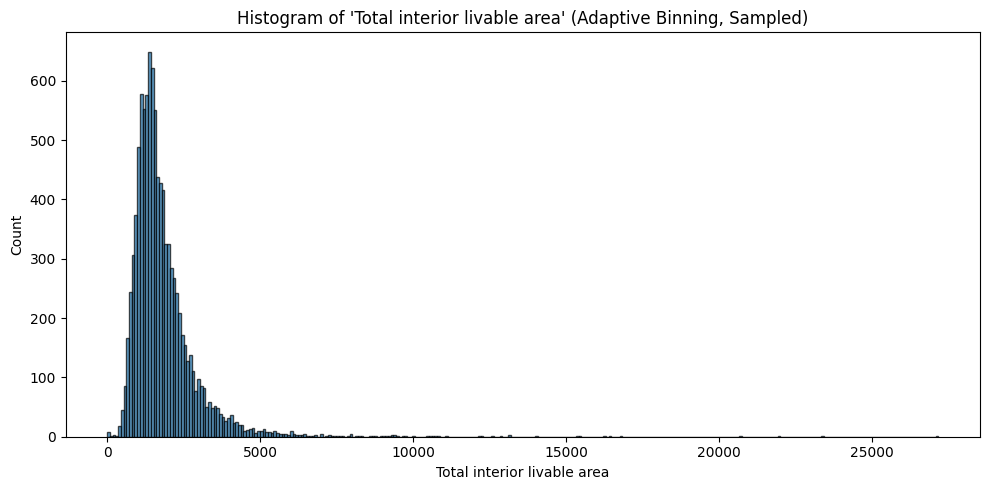

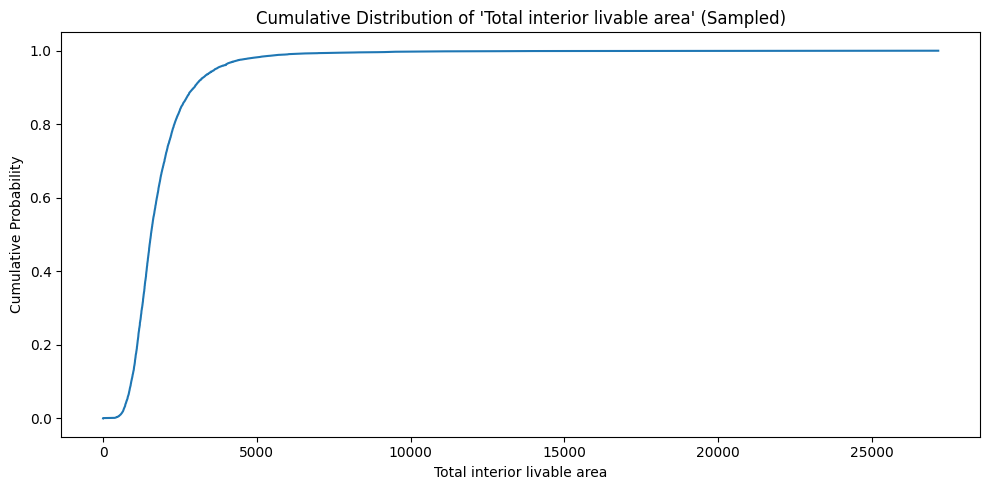

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get target series
target_series = loaded_df[dataset_config['target']]

# Subsample if too large
MAX_PLOT_ROWS = 10_000
if len(target_series) > MAX_PLOT_ROWS:
    sample = target_series.sample(MAX_PLOT_ROWS, random_state=42)
else:
    sample = target_series

# 1️⃣ Faster Histogram (Freedman-Diaconis on sample)
q25, q75 = np.percentile(sample, [25, 75])
iqr = q75 - q25
bin_width = 2 * iqr * len(sample) ** (-1/3)
bin_count = int((sample.max() - sample.min()) / bin_width)
bin_count = max(10, bin_count)

plt.figure(figsize=(10, 5))
plt.hist(sample, bins=bin_count, edgecolor='black', alpha=0.7)
plt.title(f"Histogram of '{dataset_config['target']}' (Adaptive Binning, Sampled)")
plt.xlabel(dataset_config['target'])
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# 2️⃣ Faster CDF (on sample)
sorted_sample = np.sort(sample)
cdf = np.linspace(0, 1, len(sorted_sample), endpoint=False)

plt.figure(figsize=(10, 5))
plt.plot(sorted_sample, cdf, color='tab:blue')
plt.title(f"Cumulative Distribution of '{dataset_config['target']}' (Sampled)")
plt.xlabel(dataset_config['target'])
plt.ylabel('Cumulative Probability')
plt.tight_layout()
plt.show()

In [17]:
from baseline_eval import evaluate_baseline, plot_model_performance_summary
results = evaluate_baseline(
    df=loaded_df,
    df_name=dataset_config['dataset_name'],
    label_col= dataset_config['target'],
    task_type=dataset_config['task'],
    textual_cols=textual_cols,
    k_folds=5,
    seed=0,
    max_samples=3000,
    output_path=f"../../baseline_results/{dataset_config['task']}/{dataset_config['dataset_name']}.csv"
)


[WRAPPER] Running stratified downsampling mode for task: reg
Info: 
[INFO] Downsampling dataframe: california_houses (original rows: 44913)
Downsampled 3000 rows for california_houses dataset.
  Welcome Back! Found existing access token, reusing it for authentication.


Processing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| [00:11<00:00]
Processing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| [00:11<00:00]
Processing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| [00:11<00:00]
Processing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| [00:11<00:00]
Processing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| [00:11<00:00]
Processing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| [00:11<00:00]
Processing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| [00:11<00:00]
Processing: 100%|██████████████████████████████████████████████████████████████████

In [18]:
rs = pd.read_csv(f"../../baseline_results/{dataset_config['task']}/{dataset_config['dataset_name']}.csv")
plot_model_performance_summary(name=dataset_config['dataset_name'],task=dataset_config['task'], df=rs)

Saving plot to ../../baseline_results/plots/reg/score
Saving plot to ../../baseline_results/plots/reg/loss
Saving plot to ../../baseline_results/plots/reg/roc_auc


{'score':                                mean       std
 model                                        
 TabPFN_v2API_without_text  0.726935  0.082402
 TabPFN_v2API_with_text     0.745026  0.052678,
 'loss':                                  mean         std
 model                                            
 TabPFN_v2API_with_text     633.913884   82.013094
 TabPFN_v2API_without_text  652.557719  104.522048,
 'roc_auc':                            mean  std
 model                               
 TabPFN_v2API_with_text      NaN  NaN
 TabPFN_v2API_without_text   NaN  NaN}